In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [10]:
rs=121
ns=5
stocks=['aapl','googl','nvda','dal','xom','cvx','vz']

In [11]:
init_dir_path = str(os.getcwd())
data=pd.read_csv(init_dir_path+'/stock_hmm_output.csv',engine='python').drop(['Unnamed: 0'],axis=1)
features=['Return','Volatility','HighR','LowR']
target='State'

In [12]:
#With TimeSeries
#First Set Aside Testing data
final_test=[]
l=[]
ft_size=400
for x in data.groupby(['Ticker']):
    final_test.append(x[1][-ft_size:])
    l.append(x[1][:-ft_size])

In [14]:
def createSlidingWindow(tr,te,f,t, window=7):
    splitting=SlidingWindowSplitter(window_length=window,step_length=1,fh=[1])
    train_x=[]
    train_y=[]
    test_x=[]
    test_y=[]
    
    for i in splitting.split(tr):
        train_x.append(tr.iloc[i[0]][f].values.flatten())
        train_y.append(tr.iloc[i[1]][t].values.flatten()[0])
    
    for i in splitting.split(te):
        test_x.append(te.iloc[i[0]][f].values.flatten())
        test_y.append(te.iloc[i[1]][t].values.flatten()[0])
    return ((train_x,train_y),(test_x,test_y))

In [15]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for i in range(ns):
    training_list.append([[],[]])
    testing_list.append([[],[]])
training_lists = {}
testing_lists = {}
for spread in range(7,21):
    for x in l:
        for (i,t) in enumerate(tss.split(x)):
            ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
            training_list[i][0] += train_x
            training_list[i][1] += train_y
            testing_list[i][0] += test_x
            testing_list[i][1] += test_y
    training_lists[spread] = training_list
    testing_lists[spread] = testing_list
    training_list=[]
    testing_list=[]
    for i in range(ns):
        training_list.append([[],[]])
        testing_list.append([[],[]])

In [16]:
with open('saved_training_lists.pkl', 'wb') as f:
    pickle.dump(training_lists, f)

with open('saved_testing_lists.pkl', 'wb') as f:
    pickle.dump(testing_lists, f)


In [6]:
with open('saved_training_lists.pkl', 'rb') as f:
    training_lists = pickle.load(f)

with open('saved_testing_lists.pkl', 'rb') as f:
    testing_lists = pickle.load(f)

In [7]:
def accuracies_model(model):
    accuracies = {}
    for window in training_lists.keys():
        training_list = training_lists[window]
        testing_list = testing_lists[window]
        a=0 
        for i in range(ns):
            model.fit(X=training_list[i][0],y=training_list[i][1])
            a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
        a=a/ns
        accuracies[window] = a
    return accuracies

In [17]:
model_names=['ada','decisiontree']
training_list  = training_lists[13]
testing_list = testing_lists[13]
accuracies=[]
models=[AdaBoostClassifier(n_estimators=200,random_state=121),DecisionTreeClassifier(random_state=rs)]
#Add Possible AdaBoostModels:
for m in models:
    a=0
    for i in range(ns):
        m.fit(X=training_list[i][0],y=training_list[i][1])
        a+= accuracy_score(m.predict(testing_list[i][0]),testing_list[i][1])
    a=a/ns
    accuracies.append(a)

In [18]:
accuracies

[0.7651510706952186, 0.6777354062775007]

In [19]:
training_lists.keys()

dict_keys([7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [ ]:
model_names=['ada','decisiontree']
models=[AdaBoostClassifier(n_estimators=220,learning_rate=1,random_state=rs)]
#Add Possible AdaBoostModels:
for ind, m in enumerate(models):
    acc_model = accuracies_model(m)
    plot_accuracies(acc_model, model_names[ind])

NameError: name 'plot_accuracies' is not defined

In [21]:
def plot_accuracies(accuracies, model_type):
    plt.figure(figsize=(6, 4))
    plt.plot(list(accuracies.keys()), list(accuracies.values()), marker='o')
    plt.title(f"{model_type} accuracy scores")
    plt.xlabel("Window size")
    plt.ylabel("accuracy")
    plt.tight_layout()
    plt.show()

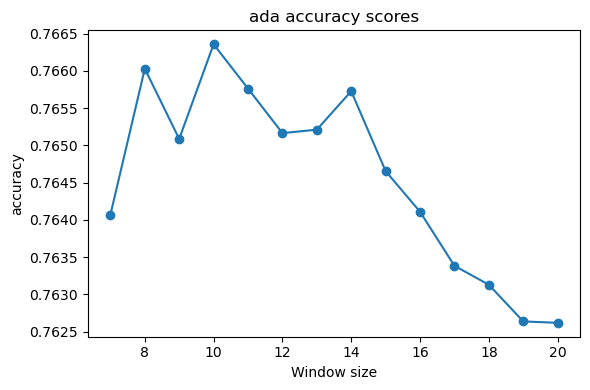

In [22]:
plot_accuracies(acc_model, model_names[ind])

In [19]:
#13 seems best from above
window=13
model=AdaBoostClassifier()

parameters = {
    'n_estimators' : [ 180, 200,220],
    'learning_rate' : [1,10]
}
grid_search = GridSearchCV(model, parameters, cv = 5, n_jobs=-1)
training_list = training_lists[window]
testing_list = testing_lists[window]
a=[] 
for i in range(ns):
    grid_search.fit(X=training_list[i][0],y=training_list[i][1])
    print(grid_search.best_estimator_)
    print(grid_search.best_score_)
    a.append(grid_search.cv_results_)

    #a+= accuracy_score(model.predict(testing_list[i][0]),testing_list[i][1])
#a=a/ns

AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.8191994720131739
AdaBoostClassifier(learning_rate=1, n_estimators=200)
0.836738932314244
AdaBoostClassifier(learning_rate=1, n_estimators=180)
0.8448664639503141
AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.850352636201106
AdaBoostClassifier(learning_rate=1, n_estimators=220)
0.8507606993751269


In [27]:
testing_size=500

tss=TimeSeriesSplit(n_splits=ns,test_size=testing_size)
training_list=[]
testing_list=[]
for j in range(len(l)):
    ttl=[]
    tstl=[]
    for i in range(ns):
        ttl.append([[],[]])
        tstl.append([[],[]])
    training_list.append(ttl)
    testing_list.append(tstl)
spread = 13
for (j,x) in enumerate(l):
    for (i,t) in enumerate(tss.split(x)):
        ((train_x,train_y),(test_x,test_y))=createSlidingWindow(x.iloc[t[0]],x.iloc[t[1]],features,target, window = spread)
        training_list[j][i][0] += train_x
        training_list[j][i][1] += train_y
        testing_list[j][i][0] += test_x
        testing_list[j][i][1] += test_y


In [35]:
stock_accuracies={}
model=AdaBoostClassifier(n_estimators=220,learning_rate=1,random_state=rs)
for (j,x) in enumerate(l):
    a=0
    for i in range(ns):
        model.fit(X=training_list[j][i][0],y=training_list[j][i][1])
        a+=accuracy_score(model.predict(testing_list[j][i][0]),testing_list[j][i][1])
    stock_accuracies[x['Ticker'].iloc[0]]=a/ns

In [36]:
stock_accuracies

{'aapl': 0.8710472279260781,
 'cvx': 0.857905544147844,
 'dal': 0.942094455852156,
 'googl': 0.686652977412731,
 'nvda': 0.6271047227926078,
 'vz': 0.8788501026694047,
 'xom': 0.8574948665297741}